In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))

In [2]:
import wget
import os

from PIL import Image
import numpy as np
import cv2
import torch
import safetensors

# Pretty visualizations of tensors
import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo
from torchvision.transforms.functional import resize

from accelerate import Accelerator
from PIL import Image
from label_anything import LabelAnything
from label_anything.models import build_lam_vit_b
from label_anything.data import get_preprocessing
from label_anything.data.transforms import PromptsProcessor
from label_anything.data import utils
from label_anything.utils.utils import torch_dict_load

Define some helper function

In [3]:
colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 1024)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def dict_to_device(d, device):
    for k, v in d.items():
        if isinstance(v, torch.Tensor):
            d[k] = v.to(device)
        if isinstance(v, dict):
            d[k] = dict_to_device(v, device)
        if isinstance(v, list):
            d[k] = [dict_to_device(vv, device) for vv in v]
        else:
            pass
    return d

### Load the Label Anything model

In [4]:
image_size = 1024
custom_preprocess = True

DEMO_PATH = "demo"

Define Label Anything parameters and initialize it

In [5]:
la = LabelAnything.from_pretrained("pasqualedem/label_anything_sam_1024_coco")

In [7]:
# # Manual loading of the model

# embed_dim = 256
# la = LabelAnything(
#     encoder="vit_b",
#     checkpoint="../checkpoints/sam_vit_b_01ec64.pth",
#     use_sam_checkpoint=True,
#     use_vit_sam_neck=False,
    
#     spatial_convs=3,
#     class_attention=False,
#     example_attention=True,
#     example_class_attention=False,
#     fusion_transformer="TwoWayTransformer",
#     image_embed_dim=768,
#     embed_dim=embed_dim,
#     image_size=image_size,
#     class_encoder=dict(
#       name="RandomMatrixEncoder",
#       bank_size=100,
#       embed_dim=embed_dim
#     ),
#     custom_preprocess=custom_preprocess
# )

# path = "../offline/wandb/latest-run/files/best/model.safetensors"

# weights = torch_dict_load(path)
# # weights = {k[6:]: v for k, v in weights.items()}
# keys = la.load_state_dict(weights, strict=False)
# assert not keys.unexpected_keys, keys.unexpected_keys
# assert all(key.startswith("model.image_encoder") for key in keys.missing_keys), keys.missing_keys

# la_not_trained = LabelAnything(
#     encoder="vit_b",
#     use_vit_sam_neck=False,
    
#     spatial_convs=3,
#     class_attention=False,
#     example_attention=True,
#     example_class_attention=False,
#     fusion_transformer="TwoWayTransformer",
#     image_embed_dim=768,
#     embed_dim=embed_dim,
#     image_size=image_size,
#     class_encoder=dict(
#       name="RandomMatrixEncoder",
#       bank_size=100,
#       embed_dim=embed_dim
#     ),
#     custom_preprocess=custom_preprocess
# )

# la_not_trained.load_state_dict(la.state_dict(), strict=False)
# la = la_not_trained

Use GPU if you have any

In [17]:
accelerator = Accelerator()
la = accelerator.prepare(la)

[2024-09-16 15:55:56] WARNING - other.py - Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Download images

In [18]:
img_dir = f"{DEMO_PATH}/images/"
os.makedirs(img_dir, exist_ok=True)

img_urls = [
    "https://farm4.staticflickr.com/3300/3339269975_a424f35e71_z.jpg",
    "http://farm6.staticflickr.com/5121/5273994775_e6dd427290_z.jpg",
]
coco_ids = [
    102555,
    554579
]

# Download
images_paths = [
    wget.download(url, out=img_dir) for id, url in zip(coco_ids, img_urls)
]

cats = ["dog", "person"]
cat_ids = [-1, 18, 1]
# -1 is the background class

images = [Image.open(img_path) for img_path in images_paths]
query_image = images[0]
support_images = images[1:]
img_sizes = [img.size for img in images]

Let's see the query image

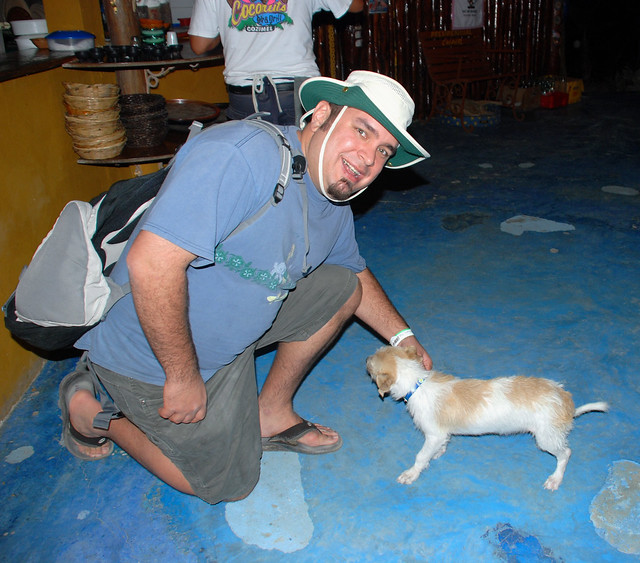

In [19]:
query_image

Preprocess images

In [20]:
preprocess = get_preprocessing(
    {
        "common": {
            "custom_preprocess": custom_preprocess,
            "image_size": image_size,
        }
    }
)

query_image = preprocess(query_image)
support_images = [preprocess(img) for img in support_images]

Initialize the prompt processor

In [21]:
prompts_processor = PromptsProcessor(
            long_side_length=image_size,
            masks_side_length=256,
            custom_preprocess=custom_preprocess,
        )


### Use only Bboxes

Define the bboxes (you can use also points and masks)

bboxes is a list where each item represent a support through a dict.

In each dict the key is the class id key and the value is the list of bboxes

In [22]:
bboxes = [
    {
        18: [
            [
                202,
                345,
                270,
                255,
            ]
        ],
        1: [[13, 55, 181, 498], [184, 65, 135, 350], [316, 82, 167, 395]],
    }
]
# Convert bbox in LA format
bboxes = [
    {
        cat_id: [
            prompts_processor.convert_bbox(
                bbox,
                *image.size,
                noise=False,
            )
            for bbox in cat_bboxes
        ]
        for cat_id, cat_bboxes in img_bboxes.items()
    }
    for img_bboxes, image in zip(bboxes, images)
]
# Add background (class -1)
bboxes = [{**{-1: []}, **bboxes} for bboxes in bboxes]

# convert the lists of prompts to arrays
for i in range(len(bboxes)):
    for cat_id in cat_ids:
        bboxes[i][cat_id] = np.array((bboxes[i][cat_id]))

In [23]:
# Here bboxes are stacked and padded in a single tensor
# flag_bboxes is used to tell the model if bbox is present or is padding
bboxes, flag_bboxes = utils.annotations_to_tensor(
            prompts_processor, bboxes, img_sizes, utils.PromptType.BBOX
        )

# Flag examples are used to tell the model each examples which class has (it is a merge of flag_bboxes, flag_masks, flag_points)
flag_examples = utils.flags_merge(flag_bboxes=flag_bboxes)

print(bboxes) # Size is (num_support_images, num_classes, num_bboxes, 4)
print(flag_bboxes) # Size is (num_support_images, num_classes)

tensor[1, 3, 3, 4] n=36 x∈[0., 960.000] μ=212.244 σ=312.551
tensor[1, 3, 3] u8 n=9 x∈[0, 1] μ=0.444 σ=0.527 [[[0, 0, 0], [1, 0, 0], [1, 1, 1]]]


Let's see the prompts

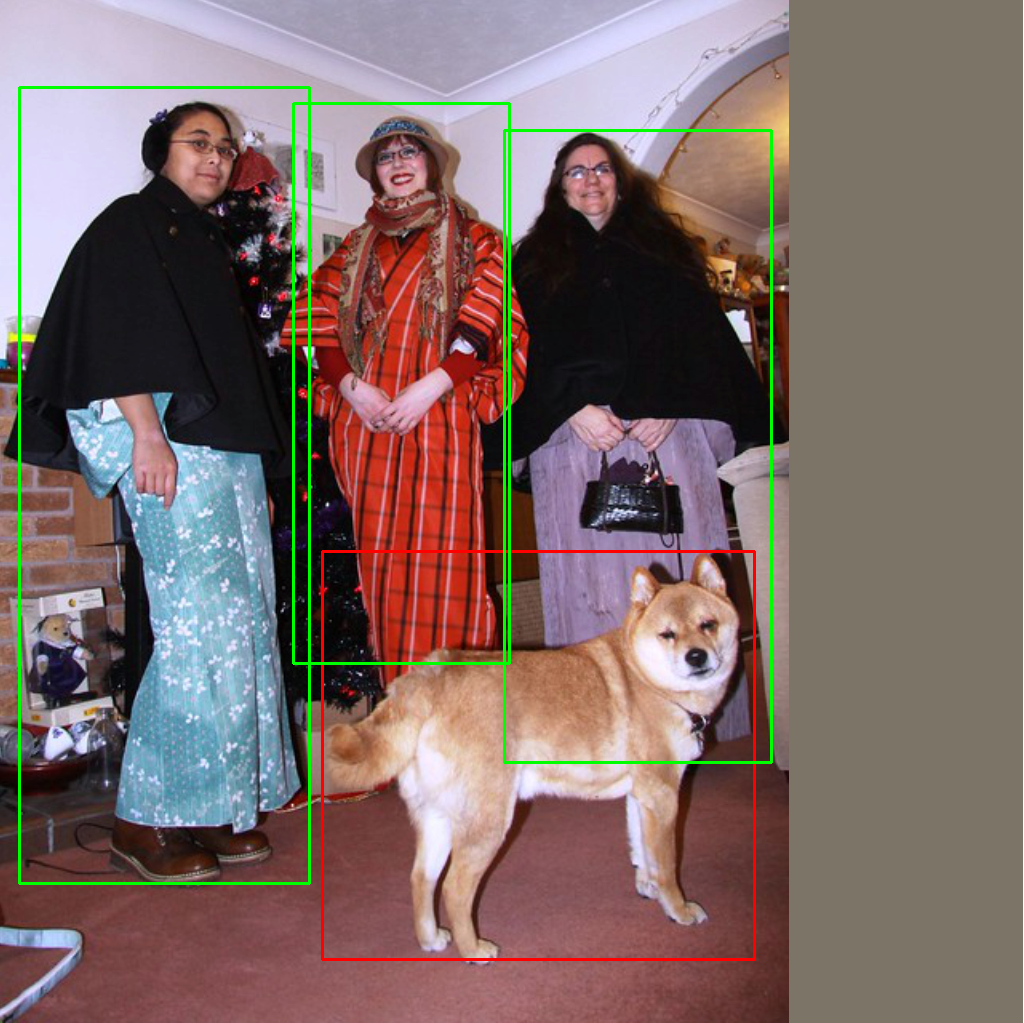

In [24]:
drawn_images = [draw_boxes(get_image(image), img_bboxes, colors) for image, img_bboxes in zip(support_images, bboxes)]
lo(drawn_images[0]).rgb

We pack together all the inputs in a single dictionary

In [25]:
input_dict = {
    utils.BatchKeys.IMAGES: torch.stack([query_image] + support_images).unsqueeze(0),
    utils.BatchKeys.PROMPT_BBOXES: bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_BBOXES: flag_bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_EXAMPLES: flag_examples.unsqueeze(0),
    utils.BatchKeys.DIMS: torch.tensor([img_sizes]),
}
# Move to device
input_dict = dict_to_device(input_dict, accelerator.device)

Calculate the prediction

In [38]:
with torch.no_grad():
    output = la(input_dict)
logits = output["logits"]

Visualize it

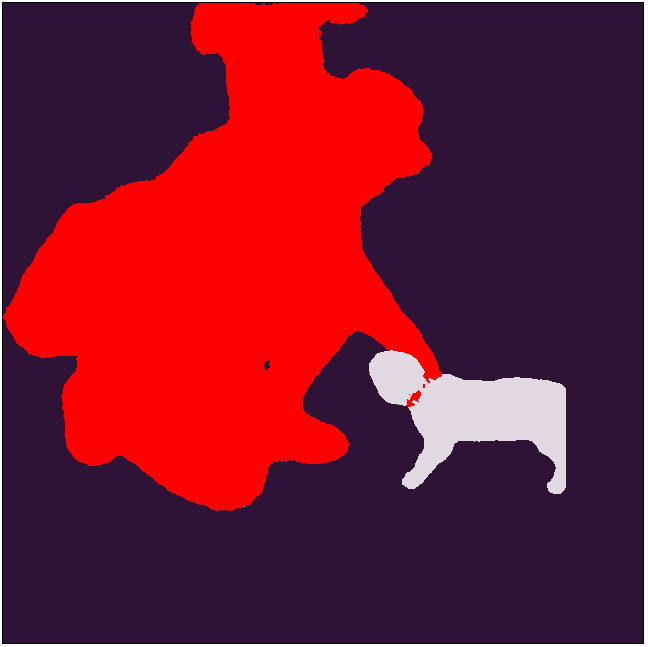

In [39]:
predictions = torch.argmax(logits, dim=1)
predictions.chans

### Use Points and Bboxes

In [18]:
points = [
    {
        18: [],
        1: [
            [370, 100],
            [380, 160],
            [375, 200],
            ],
    }
]

bboxes = [
    {
        18: [
            [
                202,
                345,
                270,
                255,
            ]
        ],
        1: [[13, 55, 181, 498], [184, 65, 135, 350]],
    }
]
# Convert bbox in LA format
bboxes = [
    {
        cat_id: [
            prompts_processor.convert_bbox(
                bbox,
                *image.size,
                noise=False,
            )
            for bbox in cat_bboxes
        ]
        for cat_id, cat_bboxes in img_bboxes.items()
    }
    for img_bboxes, image in zip(bboxes, images)
]
# Add background (class -1)
bboxes = [{**{-1: []}, **bboxes} for bboxes in bboxes]
points = [{**{-1: []}, **points} for points in points]

# convert the lists of prompts to arrays
for i in range(len(bboxes)):
    for cat_id in cat_ids:
        bboxes[i][cat_id] = np.array((bboxes[i][cat_id]))
        points[i][cat_id] = np.array((points[i][cat_id]))

In [19]:
# Here bboxes and points are stacked and padded in a single tensor
# flag_bboxes and flag_points used to tell the model if point is present or is padding
bboxes, flag_bboxes = utils.annotations_to_tensor(
            prompts_processor, bboxes, img_sizes, utils.PromptType.BBOX
        )
points, flag_points = utils.annotations_to_tensor(
            prompts_processor, points, img_sizes, utils.PromptType.POINT
        )

# Flag examples are used to tell the model each examples which class has (it is a merge of flag_bboxes, flag_masks, flag_points)
flag_examples = utils.flags_merge(flag_bboxes=flag_bboxes, flag_points=flag_points)

print(bboxes) # Size is (num_support_images, num_classes, num_bboxes, 4)
print(flag_bboxes) # Size is (num_support_images, num_classes)
print(points) # Size is (num_support_images, num_classes, num_points, 2)
print(flag_points) # Size is (num_support_images, num_classes)

tensor[1, 3, 2, 4] n=24 x∈[0., 960.000] μ=227.820 σ=319.117
tensor[1, 3, 2] u8 n=6 x∈[0, 1] μ=0.500 σ=0.548 [[[0, 0], [1, 0], [1, 1]]]
tensor[1, 3, 3, 2] n=18 x∈[0., 608.135] μ=140.911 σ=232.219
tensor[1, 3, 3] u8 n=9 x∈[0, 1] μ=0.333 σ=0.500 [[[0, 0, 0], [0, 0, 0], [1, 1, 1]]]


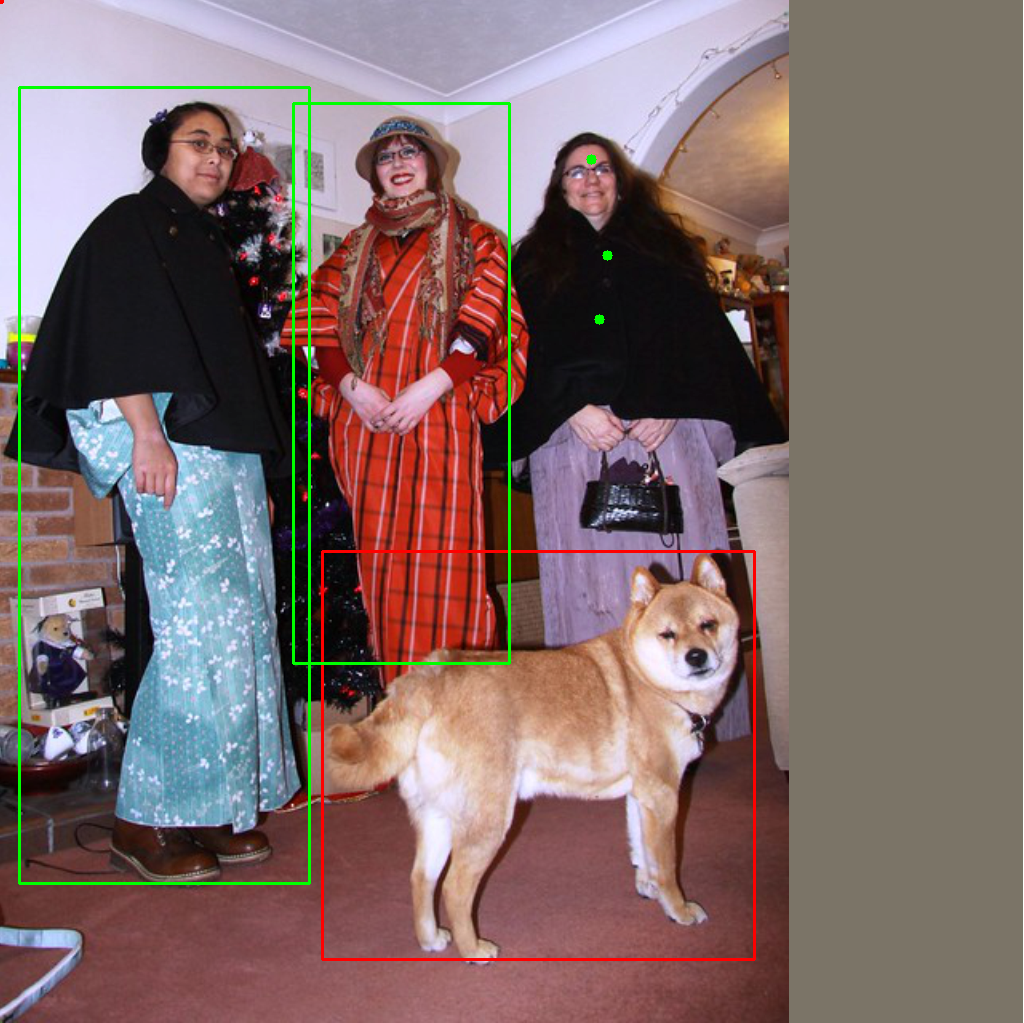

In [20]:
drawn_images = [draw_boxes(get_image(image), img_bboxes, colors) for image, img_bboxes in zip(support_images, bboxes)]
drawn_images = [draw_points(image, img_points, colors) for image, img_points in zip(drawn_images, points)]
lo(drawn_images[0]).rgb

Repeat the process with the new inputs

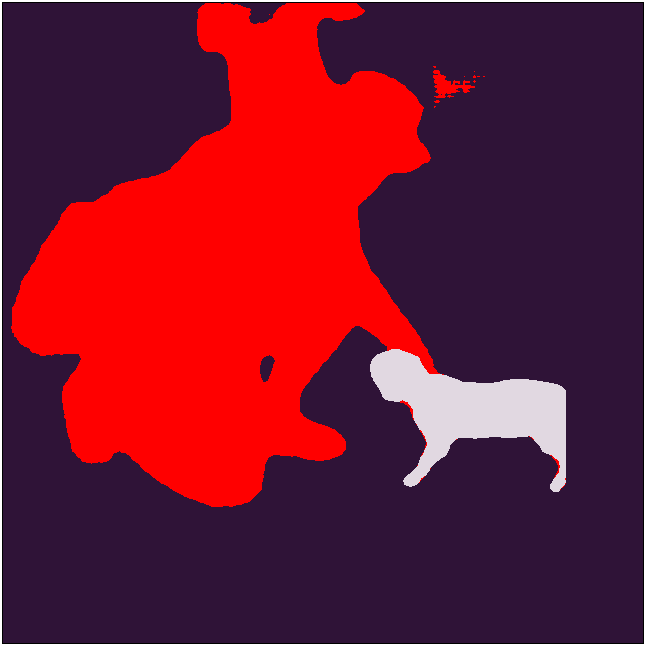

In [21]:
input_dict = {
    utils.BatchKeys.IMAGES: torch.stack([query_image] + support_images).unsqueeze(0),
    utils.BatchKeys.PROMPT_BBOXES: bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_BBOXES: flag_bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_EXAMPLES: flag_examples.unsqueeze(0),
    utils.BatchKeys.PROMPT_POINTS: points.unsqueeze(0),
    utils.BatchKeys.FLAG_POINTS: flag_points.unsqueeze(0),
    utils.BatchKeys.DIMS: torch.tensor([img_sizes]),
}
input_dict = dict_to_device(input_dict, accelerator.device)

with torch.no_grad():
    output = la(input_dict)
logits = output["logits"]

predictions = torch.argmax(logits, dim=1)
predictions.chans

### Use Points, Bboxes and masks

Load the mask

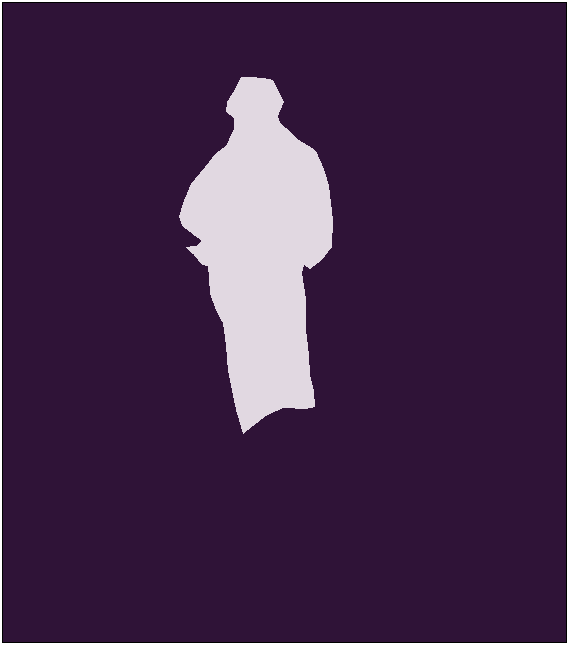

In [22]:
mask = Image.open(f"{DEMO_PATH}/mask.png")
mask = np.array(mask)
masks = [
    {
        18: [],
        1: [mask],
    }
]
lo(mask).chans

In [23]:
points = [
    {
        18: [],
        1: [
            [370, 100],
            [380, 160],
            [375, 200],
            ],
    }
]

bboxes = [
    {
        18: [
            [
                202,
                345,
                270,
                255,
            ]
        ],
        1: [[13, 55, 181, 498]],
    }
]
# Convert bbox in LA format
bboxes = [
    {
        cat_id: [
            prompts_processor.convert_bbox(
                bbox,
                *image.size,
                noise=False,
            )
            for bbox in cat_bboxes
        ]
        for cat_id, cat_bboxes in img_bboxes.items()
    }
    for img_bboxes, image in zip(bboxes, images)
]
# Add background (class -1)
bboxes = [{**{-1: []}, **bboxes} for bboxes in bboxes]
points = [{**{-1: []}, **points} for points in points]
masks = [{**{-1: []}, **masks} for masks in masks]

# convert the lists of prompts to arrays
for i in range(len(bboxes)):
    for cat_id in cat_ids:
        bboxes[i][cat_id] = np.array((bboxes[i][cat_id]))
        points[i][cat_id] = np.array((points[i][cat_id]))

In [24]:
# Here bboxes and points are stacked and padded in a single tensor
# flag_bboxes and flag_points used to tell the model if point is present or is padding
bboxes, flag_bboxes = utils.annotations_to_tensor(
            prompts_processor, bboxes, img_sizes, utils.PromptType.BBOX
        )
points, flag_points = utils.annotations_to_tensor(
            prompts_processor, points, img_sizes, utils.PromptType.POINT
        )
masks, flag_masks = utils.annotations_to_tensor(
            prompts_processor, masks, img_sizes, utils.PromptType.MASK
        )

# Flag examples are used to tell the model each examples which class has (it is a merge of flag_bboxes, flag_masks, flag_points)
flag_examples = utils.flags_merge(flag_bboxes=flag_bboxes, flag_points=flag_points, flag_masks=flag_masks)

print(bboxes) # Size is (num_support_images, num_classes, num_bboxes, 4)
print(flag_bboxes) # Size is (num_support_images, num_classes)
print(points) # Size is (num_support_images, num_classes, num_points, 2)
print(flag_points) # Size is (num_support_images, num_classes)
print(masks) # Size is (num_support_images, num_classes, 256, 256)
print(flag_masks) # Size is (num_support_images, num_classes)

tensor[1, 3, 1, 4] n=12 x∈[0., 960.000] μ=324.559 σ=372.310
tensor[1, 3, 1] u8 x∈[0, 1] μ=0.667 σ=0.577 [[[0], [1], [1]]]
tensor[1, 3, 3, 2] n=18 x∈[0., 608.135] μ=140.911 σ=232.219
tensor[1, 3, 3] u8 n=9 x∈[0, 1] μ=0.333 σ=0.500 [[[0, 0, 0], [0, 0, 0], [1, 1, 1]]]
tensor[1, 3, 256, 256] n=196608 (0.8Mb) x∈[0., 1.000] μ=0.026 σ=0.160
tensor[1, 3] u8 x∈[0, 1] μ=0.333 σ=0.577 [[0, 0, 1]]


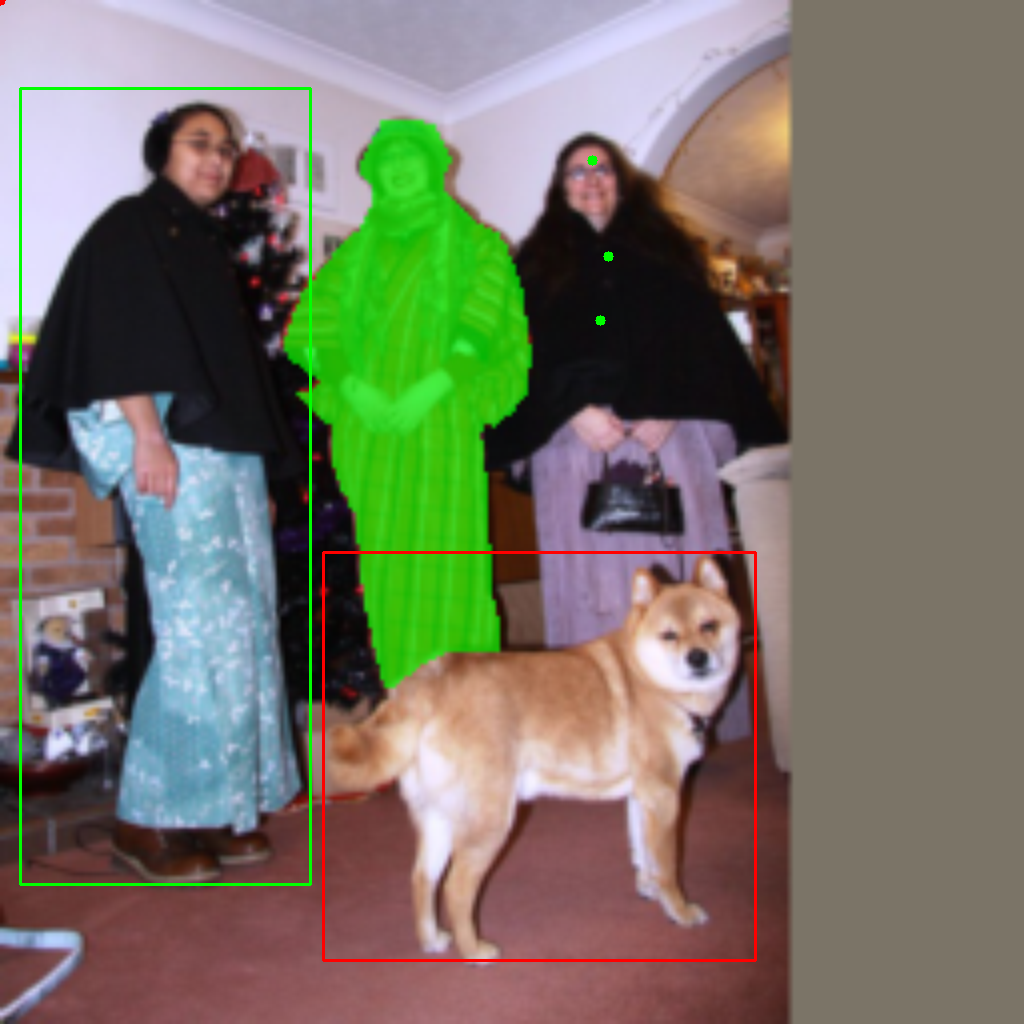

In [25]:
drawn_images = [
    draw_all(get_image(image), img_masks, img_bboxes, img_points, colors)
    for image, img_masks, img_bboxes, img_points in zip(
        support_images, masks, bboxes, points
    )
]
drawn_images[0]

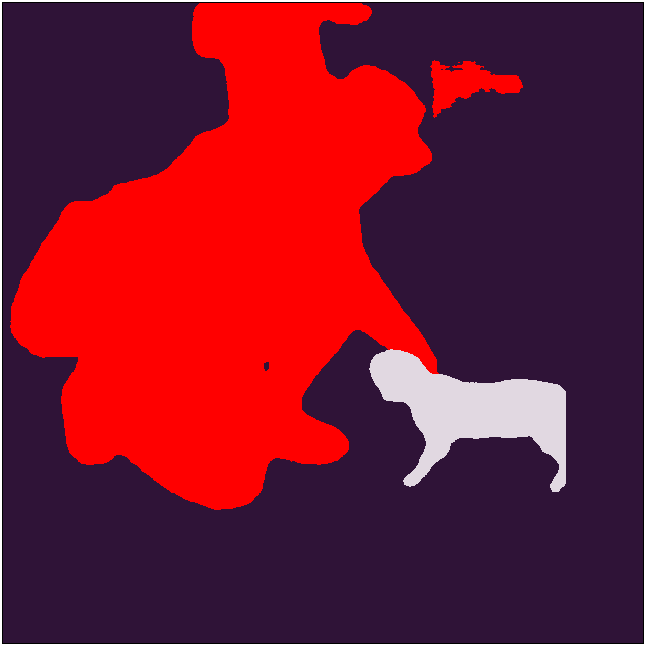

In [26]:
input_dict = {
    utils.BatchKeys.IMAGES: torch.stack([query_image] + support_images).unsqueeze(0),
    utils.BatchKeys.PROMPT_BBOXES: bboxes.unsqueeze(0),
    utils.BatchKeys.FLAG_BBOXES: flag_bboxes.unsqueeze(0),
    utils.BatchKeys.PROMPT_POINTS: points.unsqueeze(0),
    utils.BatchKeys.FLAG_POINTS: flag_points.unsqueeze(0),
    utils.BatchKeys.PROMPT_MASKS: masks.unsqueeze(0),
    utils.BatchKeys.FLAG_MASKS: flag_masks.unsqueeze(0),
    utils.BatchKeys.FLAG_EXAMPLES: flag_examples.unsqueeze(0),
    utils.BatchKeys.DIMS: torch.tensor([img_sizes]),
}
input_dict = dict_to_device(input_dict, accelerator.device)

with torch.no_grad():
    output = la(input_dict)
logits = output["logits"]

predictions = torch.argmax(logits, dim=1)
predictions.chans